# Loading the data

In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
import glob
import pandas as pd
from pathlib import Path

pd.set_option('display.max_columns', None)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
CV_TYPE = 'loco'

model_name = 'ProjNetMerged4'
filepaths = glob.glob('/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/'
    f'models/predict_{CV_TYPE}/{model_name}/perf/*')

filepaths.sort()
filepath = filepaths[-1]
print(filepath)

center_colors = {
    'Bern' : '#d7191c',
    'Cologne' : '#2c7bb6',
    'All' : '#5e3c99'
}

df = pd.read_csv(filepath)


/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/models/predict_loco/ProjNetMerged4/perf/23.09.28.15:54:57.csv


In [4]:
df[(df['noisy'] == False) & (df['tweening'] == False)].groupby(['center'])['total_voxels'].describe()

,count,mean,std,min,25%,50%,75%,max
center,,,,,,,,
Bern,4740.0,83.695781,74.568528,0.0,23.0,61.0,121.0,309.0
Cologne,815.0,52.824540,40.761455,0.0,17.0,46.0,85.0,141.0


In [15]:
import pingouin as pg

levels = (0, 16, 17, 7, 8, 18, 19, 15)
contacts = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
contact_to_levels = {
    0 : 0,
    16 : 1,
    17 : 2,
    7 : 3,
    8 : 0,
    18 : 1,
    19 : 2,
    15 : 3}
contact_to_hemisphere_lvl = {
    0 : 'right',
    16 : 'right',
    17 : 'right',
    7 : 'right',
    8 : 'left',
    18 : 'left',
    19 : 'left',
    15 : 'left'}
contact_to_hemisphere_cnt = {
    0 : 'right',
    1 : 'right',
    2 : 'right',
    3 : 'right',
    4 : 'right',
    5 : 'right',
    6 : 'right', 
    7 : 'right',
    8 : 'left',
    9 : 'left',
    10 : 'left',
    11 : 'left',
    12 : 'left',
    13 : 'left',
    14 : 'left',
    15 : 'left'}

vercise_to_hemisphere = {
    0 : 'right',
    1 : 'right',
    2 : 'right',
    3 : 'right',
    4 : 'right',
    5 : 'right',
    6 : 'right', 
    7 : 'right',
    16 : 'right',
    17 : 'right',
    8 : 'left',
    9 : 'left',
    10 : 'left',
    11 : 'left',
    12 : 'left',
    13 : 'left',
    14 : 'left',
    15 : 'left',
    18 : 'left',
    19 : 'left'}


from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, precision_score,  recall_score 
    
def get_tn(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred).ravel()
    if len(conf) < 4:
        return 0
    else:
        return conf[0]
    
def get_fp(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred).ravel()
    if len(conf) < 4:
        return 0
    else:
        return conf[1]

def get_fn(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred).ravel()
    if len(conf) < 4:
        return 0
    else:
        return conf[2]

def get_tp(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred).ravel()
    if len(conf) < 4:
        return conf[0]
    else:
        return conf[3]

def get_total(y_true, y_pred):
    return sum(confusion_matrix(y_true, y_pred).ravel())

def get_dict_metrics(df, label_str, prediction_str, mapping, FN_add):

    data_dict = {}

    for center in ('Bern', 'Cologne'):
        if mapping:
            df_sub = df[(df['center'] == center) & (df['mapping'] == True)]
        else:
            df_sub = df[df['center'] == center]

        labels = df_sub[label_str].to_numpy().astype(int)
        preds = df_sub[prediction_str].to_numpy().astype(int)
        TN, TP, FN, FP = get_tn(labels, preds), get_tp(labels, preds), get_fn(labels, preds), get_fp(labels, preds)
        data_dict[center] = {
            'center' : center,
            'type' : 'level VTA classification',
            'TN' : TN,
            'TP' : TP,
            'FN' : FN + FN_add,
            'FP' : FP,
            'Total' : len(labels),
            'acc' : accuracy_score(labels, preds),
            'bal_acc' : balanced_accuracy_score(labels, preds),
            'f1' : f1_score(labels, preds),
            'mcc' : matthews_corrcoef(labels, preds),
            'recall/sensitivity/hit rate (TPR)' : recall_score(labels, preds),
            'specificity/selectivity (TNR)' : TN / (TN + FP),
            'precision (PPV)' : precision_score(labels, preds)
        }

    return data_dict



def process_predictions(df, display=True, label_threshold=0.99999, filter_tweening=True):

    # PREPROCESSING
    if filter_tweening:
        df = df[df['tweening'] == False]
        
    df = df[df['noisy'] == False]
    df = df.drop(columns = ['massive_filename'])
    df = df.drop(columns = ['lead_model', 'contact', 'step_interp_score', 'part', 'lin_interp_score', 'tweening', 'prediction_rounded'])
    df = df.rename(columns={'mapping_score' : 'label'})
    #df['label'] = df['label'].apply(np.floor).astype('Int64')
    df['label'] = df['label'].apply(lambda x : np.where(x > label_threshold, 1, 0)).astype('Int64')

    df['prediction'] = df['prediction'].apply(np.round).astype(int)
    if CV_TYPE == 'lopo' :
        df['merged_prediction'] = df['merged_prediction'].apply(np.round).astype(int)


    df['hemisphere'] = df['vercise'].map(vercise_to_hemisphere)
    df['lead'] = df.apply(lambda row: row['patient'] + 0.5 if row['hemisphere'] == 'left' else row['patient'] + 0.0, axis=1)

    # LEVELS

    df_levels = df.drop(df[~df['vercise'].isin(levels)].index)
    df_levels['level'] = df_levels['vercise'].map(contact_to_levels).astype(int)

    df_levels = df_levels.drop(columns = ['vercise'])

    pred_levels_min = df_levels[df_levels.prediction == 1] \
        .groupby(['center', 'patient', 'lead', 'hemisphere', 'level'])['amplitude'] \
        .agg(min) \
        .reset_index()
    pred_levels_min['best_level_rank'] = pred_levels_min.groupby(['center', 'patient', 'lead', 'hemisphere'])['amplitude'].rank('min').astype(int)
    pred_levels_min['best_level'] = (pred_levels_min['best_level_rank'] == 1)

    if CV_TYPE == 'lopo' :
        pred_levels_min_m = df_levels[df_levels.merged_prediction > 0.5] \
            .groupby(['center', 'patient', 'lead', 'hemisphere', 'level'])['amplitude'] \
            .agg(min) \
            .reset_index()
        pred_levels_min_m['best_level_rank'] = pred_levels_min.groupby(['center', 'patient', 'lead', 'hemisphere'])['amplitude'].rank('min').astype(int)
        pred_levels_min_m['best_level'] = (pred_levels_min['best_level_rank'] == 1)

    a = df_levels.label == 1
    b = df_levels.mapping == 1
    label_levels_min = df_levels.loc[a & b, :] \
        .groupby(['center', 'patient', 'lead', 'hemisphere', 'level'])['amplitude'] \
        .agg(min) \
        .reset_index()
    label_levels_min['best_level_rank'] = label_levels_min.groupby(['center', 'patient', 'lead', 'hemisphere'])['amplitude'].rank('min').astype(int)
    label_levels_min['best_level'] = (label_levels_min['best_level_rank'] == 1)
    all_level_combinations = set(df_levels[df_levels['label'] == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'level']).groups.keys())    
    pred_level_combinations = set(df_levels[df_levels['prediction'] == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'level']).groups.keys())
    missing_level_combinations = all_level_combinations - pred_level_combinations
    FN_levels = len(missing_level_combinations)


    level_comparison_df = pd.merge(pred_levels_min, label_levels_min, how='inner', on=['center', 'patient', 'lead', 'hemisphere', 'level'], suffixes=('_pred', '_label'))
    level_comparison_df.loc[:, 'matching?'] = (level_comparison_df.loc[:, 'best_level_pred'] == level_comparison_df.loc[:, 'best_level_label'])

    level_comparison_df.loc[:,'effect_threshold_error'] = abs(level_comparison_df.loc[:,'amplitude_pred'] - level_comparison_df.loc[:,'amplitude_label'])

    if CV_TYPE == 'lopo' :
        level_comparison_m_df = pd.merge(pred_levels_min_m, label_levels_min, how='inner', on=['center', 'patient', 'lead', 'hemisphere', 'level'], suffixes=('_pred', '_label'))
        level_comparison_m_df.loc[:, 'matching?'] = (level_comparison_df.loc[:, 'best_level_pred'] == level_comparison_df.loc[:, 'best_level_label'])

    # CONTACTS

    df_contacts = df.drop(df[~df['vercise'].isin(contacts)].index)
    df_contacts = df_contacts.rename(columns={'vercise' : 'contact'})
    df_contacts['hemisphere'] = df_contacts['contact'].map(contact_to_hemisphere_cnt)

    pred_contacts_min = df_contacts[df_contacts.prediction == 1] \
        .groupby(['center', 'patient', 'lead', 'hemisphere', 'contact'])['amplitude'] \
        .agg(min) \
        .reset_index()
    pred_contacts_min['best_contact_rank'] = pred_contacts_min.groupby(['center', 'patient', 'lead', 'hemisphere'])['amplitude'].rank('min').astype(int)
    pred_contacts_min['best_contact'] = (pred_contacts_min['best_contact_rank'] == 1)

    a = df_contacts.label == 1
    b = df_contacts.mapping == 1
    label_contacts_min = df_contacts[a & b] \
        .groupby(['center', 'patient', 'lead', 'hemisphere', 'contact'])['amplitude'] \
        .agg(min) \
        .reset_index()
    label_contacts_min['best_contact_rank'] = label_contacts_min.groupby(['center', 'patient', 'lead', 'hemisphere'])['amplitude'].rank('min').astype(int)
    label_contacts_min['best_contact'] = (label_contacts_min['best_contact_rank'] == 1)

    all_contact_combinations = set(df_contacts[df_contacts['label'] == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'contact']).groups.keys())    
    pred_contact_combinations = set(df_contacts[df_contacts['prediction'] == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'contact']).groups.keys())
    missing_contact_combinations = all_contact_combinations - pred_contact_combinations
    FN_contacts = len(missing_contact_combinations)

    contact_comparison_df = pd.merge(pred_contacts_min, label_contacts_min, how='inner', on=['center', 'patient', 'lead', 'hemisphere','contact'], suffixes=('_pred', '_label'))
    contact_comparison_df.loc[:, 'matching?'] = (contact_comparison_df.loc[:, 'best_contact_pred'] == contact_comparison_df.loc[:, 'best_contact_label'])

    contact_comparison_df.loc[:,'effect_threshold_error'] = abs(contact_comparison_df.loc[:,'amplitude_pred'] - contact_comparison_df.loc[:,'amplitude_label'])   

    # BEST CONTACT/LEVEL METRICS

    lvl_dict, cnt_dict = {} , {}

    #data_dict = get_dict_metrics(level_comparison_df, label_str='best_level_label', prediction_str='best_level_pred', mapping=False, FN_add=FN_levels)

    for center in ('Bern', 'Cologne'):
        lvl_cmp = level_comparison_df[level_comparison_df['center'] == center]

        best_level_pred = lvl_cmp['best_level_pred'].to_numpy().astype(int)
        best_level_label = lvl_cmp['best_level_label'].to_numpy().astype(int)
        TN = get_tn(best_level_label, best_level_pred)
        TP = get_tp(best_level_label, best_level_pred)
        FN = get_fn(best_level_label, best_level_pred) #+ FN_levels
        FP = get_fp(best_level_label, best_level_pred)
        
        total_contacts = TN + TP + FN + FP
        acc = (TP + TN) / total_contacts
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        specificity = TN / (TN + FP)
        bal_acc = (recall + specificity) / 2  # Balanced Accuracy
        f1 = 2 * (precision * recall) / (precision + recall)
        mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        
        lvl_dict[center] = {
            'center' : center,
            'type' : 'best level',
            'TN' : TN,
            'TP' : TP,
            'FP' : FP,
            'FN': FN,
            'Total': total_contacts,
            'acc': acc,
            'bal_acc' : bal_acc,
            'recall (TPR)' : recall,
            'specificity (TNR)' : specificity,
            'precision' : precision,
            'f1': f1,
            'mcc': mcc
        }

        cnt_cmp = contact_comparison_df[contact_comparison_df['center'] == center]

        best_contact_pred = cnt_cmp['best_contact_pred'].to_numpy().astype(int)
        best_contact_label = cnt_cmp['best_contact_label'].to_numpy().astype(int)
        TN = get_tn(best_contact_label, best_contact_pred)
        TP = get_tp(best_contact_label, best_contact_pred)
        FN = get_fn(best_contact_label, best_contact_pred) #+ FN_contacts
        FP = get_fp(best_contact_label, best_contact_pred)
        
        total_contacts = TN + TP + FN + FP
        acc = (TP + TN) / total_contacts
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        specificity = TN / (TN + FP)
        bal_acc = (recall + specificity) / 2  # Balanced Accuracy
        f1 = 2 * (precision * recall) / (precision + recall)
        mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        
        cnt_dict[center] = {
            'center' : center,
            'type' : 'best contact',
            'TN' : TN,
            'TP' : TP,
            'FP' : FP,
            'FN': FN,
            'Total': total_contacts,
            'acc': acc,
            'bal_acc' : bal_acc,
            'recall (TPR)' : recall,
            'specificity (TNR)' : specificity,
            'precision' : precision,
            'f1': f1,
            'mcc': mcc
        }

    metrics_df = pd.DataFrame(data= [lvl_dict['Bern'], lvl_dict['Cologne'], cnt_dict['Bern'], cnt_dict['Cologne']])

    for center in ('Bern', 'Cologne'):
        lvl_cmp = df_levels[(df_levels['center'] == center) & (df_levels['mapping'] == True)]

        labels = lvl_cmp['label'].to_numpy().astype(int)
        preds = lvl_cmp['prediction'].to_numpy().astype(int)
        TN, TP, FN, FP = get_tn(labels, preds), get_tp(labels, preds), get_fn(labels, preds), get_fp(labels, preds)
        lvl_dict[center] = {
            'center' : center,
            'type' : 'level VTA classification',
            'TN' : TN,
            'TP' : TP,
            'FN' : FN,
            'FP' : FP,
            'Total' : len(labels),
            'acc' : accuracy_score(labels, preds),
            'bal_acc' : balanced_accuracy_score(labels, preds),
            'f1' : f1_score(labels, preds),
            'mcc' : matthews_corrcoef(labels, preds),
            'recall (TPR)' : recall_score(labels, preds),
            'specificity (TNR)' : TN / (TN + FP),
            'precision' : precision_score(labels, preds)
        }

        cnt_cmp = df_contacts[(df_contacts['center'] == center) & (df_contacts['mapping'] == True)]

        labels = cnt_cmp['label'].to_numpy().astype(int)
        preds = cnt_cmp['prediction'].to_numpy().astype(int)
        TN, TP, FN, FP = get_tn(labels, preds), get_tp(labels, preds), get_fn(labels, preds), get_fp(labels, preds)
        cnt_dict[center] = {
            'center' : center,
            'type' : 'contact VTA classification',
            'TN' : TN,
            'TP' : TP,
            'FN' : FN,
            'FP' : FP,
            'Total' : len(labels),
            'acc' : accuracy_score(labels, preds),
            'bal_acc' : balanced_accuracy_score(labels, preds),
            'f1' : f1_score(labels, preds),
            'mcc' : matthews_corrcoef(labels, preds),
            'recall (TPR)' : recall_score(labels, preds),
            'specificity (TNR)' : TN / (TN + FP),
            'precision' : precision_score(labels, preds)
        }

    metrics_df_vta = pd.DataFrame(data= [lvl_dict['Bern'], lvl_dict['Cologne'], cnt_dict['Bern'], cnt_dict['Cologne']])

    metrics_df = pd.concat([metrics_df, metrics_df_vta], axis=0)

    # REPEATED MEASURED CORRELATION

    cnt_stats_bern = pg.rm_corr(data=contact_comparison_df[contact_comparison_df['center'] == 'Bern'], x='best_contact_rank_pred', y='best_contact_rank_label', subject='lead')
    cnt_stats_bern.index = ['Bern']
    cnt_stats_cologne = pg.rm_corr(data=contact_comparison_df[contact_comparison_df['center'] == 'Cologne'], x='best_contact_rank_pred', y='best_contact_rank_label', subject='lead')
    cnt_stats_cologne.index = ['Cologne']
    cnt_stats = pd.concat([cnt_stats_bern, cnt_stats_cologne], names=['Bern', 'Cologne'], axis=0)

    lvl_stats_bern = pg.rm_corr(data=level_comparison_df[level_comparison_df['center'] == 'Bern'], x='best_level_rank_pred', y='best_level_rank_label', subject='lead')
    lvl_stats_bern.index = ['Bern']
    lvl_stats_cologne = pg.rm_corr(data=level_comparison_df[level_comparison_df['center'] == 'Cologne'], x='best_level_rank_pred', y='best_level_rank_label', subject='lead')
    lvl_stats_cologne.index = ['Cologne']
    lvl_stats = pd.concat([lvl_stats_bern, lvl_stats_cologne], names=['Bern', 'Cologne'], axis=0)

    # DISPLAY

    if display:
        for center in ('Bern', 'Cologne'):
            print(f"{center} Level: # predictions : {len(pred_levels_min[pred_levels_min['center'] == center])}, # labels : {len(label_levels_min[label_levels_min['center'] == center])}, # comparisons : {len(level_comparison_df[level_comparison_df['center'] == center])}")
            print(f"{center} Contact: # predictions : {len(pred_contacts_min[pred_contacts_min['center'] == center])}, # labels : {len(label_contacts_min[label_contacts_min['center'] == center])}, # comparisons : {len(contact_comparison_df[contact_comparison_df['center'] == center])}")

            print(f"{center} Level : ET mean : {level_comparison_df[level_comparison_df['center'] == center]['effect_threshold_error'].mean()}, ET std : {level_comparison_df[level_comparison_df['center'] == center]['effect_threshold_error'].std()}")
            print(f"{center} Contact : ET mean : {contact_comparison_df[contact_comparison_df['center'] == center]['effect_threshold_error'].mean()}, ET std : {contact_comparison_df[contact_comparison_df['center'] == center]['effect_threshold_error'].std()}")
        
        print(f"# mapping VTAs : {len(df[df.mapping == 1])}")
        print(f"# mapping VTAs level: {len(df_levels[df_levels.mapping == 1])}")
        print(f"# mapping VTAs contact: {len(df_contacts[df_contacts.mapping == 1])}")
        print(f"# reviewed levels : {df_levels[df_levels.mapping == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'level']).ngroups}")
        print(f"# reviewed contacts : {df_contacts[df_contacts.mapping == 1].groupby(['center', 'patient', 'lead', 'hemisphere', 'contact']).ngroups}")

    return contact_comparison_df, level_comparison_df, cnt_stats, lvl_stats, metrics_df, df_contacts, df_levels


In [16]:
projnet_merged4_label_threshold = 0.8330957480952411

contact_comparison_df, level_comparison_df, cnt_stats, lvl_stats, metrics_df, df_contacts, df_levels = process_predictions(df, filter_tweening=False)

Bern Level: # predictions : 197, # labels : 197, # comparisons : 196
Bern Contact: # predictions : 405, # labels : 407, # comparisons : 404
Bern Level : ET mean : 0.14693877551020415, ET std : 0.09359386527414326
Bern Contact : ET mean : 0.14554455445544562, ET std : 0.1003959925996748
Cologne Level: # predictions : 24, # labels : 9, # comparisons : 6
Cologne Contact: # predictions : 39, # labels : 22, # comparisons : 18
Cologne Level : ET mean : 0.6833333333333335, ET std : 0.331159578853861
Cologne Contact : ET mean : 0.8444444444444444, ET std : 0.8016323216319108
# mapping VTAs : 1000
# mapping VTAs level: 489
# mapping VTAs contact: 717
# reviewed levels : 331
# reviewed contacts : 587


/tmp/ipykernel_79542/2762946331.py:161: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  .agg(min) \
/tmp/ipykernel_79542/2762946331.py:178: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  .agg(min) \
/tmp/ipykernel_79542/2762946331.py:205: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  .agg(min) \
/tmp/ipykernel_79542/2762946331.py:214: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the prov

In [17]:
df_cb = df_contacts[(df_contacts['center'] == 'Bern') & (df_contacts['mapping'] == True)]
df_cc = df_contacts[(df_contacts['center'] == 'Cologne') & (df_contacts['mapping'] == True)]

df_cc[(df_cc['prediction'] == 0) & (df_cc['label'] == 1)] #FN

,center,cohort,patient,lead,hemisphere,contact,directional,ring,segmented,amplitude,label,mapping,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9,split_10,noisy,original_vta,added_voxels,total_voxels,prediction
21514,Cologne,C01,208,208.0,right,7,False,R3,NaN,4.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,86.0,0
21519,Cologne,C01,208,208.0,right,7,False,R3,NaN,5.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,126.0,0
21648,Cologne,C01,211,211.0,right,0,False,R0,NaN,3.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,47.0,0
21660,Cologne,C01,211,211.0,right,0,False,R0,NaN,5.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,125.0,0
22932,Cologne,C02,231,231.0,right,2,True,NaN,R1_2,3.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,45.0,0
22983,Cologne,C02,231,231.5,left,12,True,NaN,R2_1,2.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,19.0,0
23042,Cologne,C02,231,231.5,left,14,True,NaN,R2_3,3.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,48.0,0
23077,Cologne,C02,232,232.0,right,1,True,NaN,R1_1,3.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,48.0,0
23459,Cologne,C02,235,235.0,right,2,True,NaN,R1_2,2.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,25.0,0
23603,Cologne,C02,236,236.5,left,14,True,NaN,R2_3,3.0,1,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,52.0,0


In [18]:
df_cc[(df_cc['prediction'] == 1) & (df_cc['label'] == 0)] #Fp

,center,cohort,patient,lead,hemisphere,contact,directional,ring,segmented,amplitude,label,mapping,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9,split_10,noisy,original_vta,added_voxels,total_voxels,prediction
21217,Cologne,C01,205,205.0,right,7,False,R3,NaN,5.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,126.0,1
21808,Cologne,C01,214,214.0,right,0,False,R0,NaN,3.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,49.0,1
22341,Cologne,C01,218,218.0,right,0,False,R0,NaN,5.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,124.0,1
22607,Cologne,C01,223,223.5,left,8,False,R0,NaN,4.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,85.0,1
23299,Cologne,C02,233,233.5,left,13,True,NaN,R2_2,3.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,55.0,1
23326,Cologne,C02,233,233.5,left,14,True,NaN,R2_3,3.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,54.0,1
23334,Cologne,C02,233,233.5,left,14,True,NaN,R2_3,4.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,81.0,1
23876,Cologne,C02,238,238.5,left,9,True,NaN,R1_1,5.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,132.0,1
24043,Cologne,C02,239,239.5,left,9,True,NaN,R1_1,4.0,0,1.0,testing,testing,testing,testing,testing,testing,testing,testing,testing,testing,False,NaN,0.0,82.0,1


## Best level metrics

In [7]:
level_comparison_df

,center,patient,lead,hemisphere,level,amplitude_pred,best_level_rank_pred,best_level_pred,amplitude_label,best_level_rank_label,best_level_label,matching?,effect_threshold_error
0,Bern,1,1.0,right,1,3.8,2,False,4.0,2,False,True,0.2
1,Bern,1,1.0,right,2,4.3,3,False,4.5,3,False,True,0.2
2,Bern,1,1.0,right,3,3.3,1,True,3.5,1,True,True,0.2
3,Bern,1,1.5,left,1,3.0,3,False,3.0,3,False,True,0.0
4,Bern,1,1.5,left,2,1.9,1,True,2.0,1,True,True,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Cologne,208,208.5,left,2,4.4,1,True,4.0,1,True,True,0.4
198,Cologne,211,211.0,right,1,2.9,1,True,4.0,2,False,False,1.1
199,Cologne,211,211.0,right,2,4.8,2,False,4.0,2,False,True,0.8
200,Cologne,222,222.0,right,2,2.9,2,False,2.0,1,True,False,0.9


In [8]:
contact_comparison_df

,center,patient,lead,hemisphere,contact,amplitude_pred,best_contact_rank_pred,best_contact_pred,amplitude_label,best_contact_rank_label,best_contact_label,matching?,effect_threshold_error
0,Bern,1,1.0,right,1,2.8,2,False,3.0,2,False,True,0.2
1,Bern,1,1.0,right,2,3.3,4,False,3.5,4,False,True,0.2
2,Bern,1,1.0,right,3,2.3,1,True,2.5,1,True,True,0.2
3,Bern,1,1.0,right,5,3.8,6,False,4.0,6,False,True,0.2
4,Bern,1,1.0,right,6,2.9,3,False,3.0,2,False,True,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,Cologne,238,238.0,right,5,2.3,2,False,1.0,1,True,False,1.3
418,Cologne,238,238.0,right,6,1.8,1,True,1.0,1,True,True,0.8
419,Cologne,239,239.0,right,2,3.0,1,True,3.0,1,True,True,0.0
420,Cologne,239,239.0,right,3,3.4,2,False,3.0,1,True,False,0.4


In [44]:
metrics_df

,center,type,TN,TP,FP,FN,Total,acc,bal_acc,recall (TPR),specificity (TNR),precision,f1,mcc
0,Bern,best level,90,87,2,17,196,0.903061,0.907400,0.836538,0.978261,0.977528,0.901554,0.816722
1,Cologne,best level,1,2,2,1,6,0.500000,0.500000,0.666667,0.333333,0.500000,0.571429,0.000000
2,Bern,best contact,278,98,1,27,404,0.930693,0.890208,0.784000,0.996416,0.989899,0.875000,0.838717
3,Cologne,best contact,2,8,2,6,18,0.555556,0.535714,0.571429,0.500000,0.800000,0.666667,0.059761
0,Bern,level VTA classification,60,187,0,10,257,0.961089,0.974619,0.949239,1.000000,1.000000,0.973958,0.902016
1,Cologne,level VTA classification,194,7,23,8,232,0.866379,0.680338,0.466667,0.894009,0.233333,0.311111,0.264336
2,Bern,contact VTA classification,101,389,0,18,508,0.964567,0.977887,0.955774,1.000000,1.000000,0.977387,0.900668
3,Cologne,contact VTA classification,163,16,9,21,209,0.856459,0.690053,0.432432,0.947674,0.640000,0.516129,0.447087


In [31]:
if CV_TYPE == 'lopo' :
    level_comparison_m_df

In [32]:
if CV_TYPE == 'lopo' :
    metrics_m_df = compute_metrics_df(level_comparison_m_df, 'level')
    metrics_m_df

## Effect Threshold Error

/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

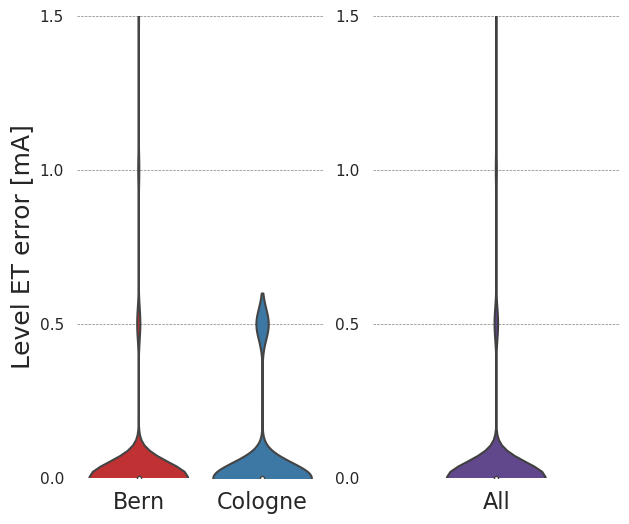

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color

sns.set()

def hex_to_rgba(hex_str, alpha=1.0):
    rgb = hex2color(hex_str)  # This will convert '#XXXXXX' format to a (r, g, b) tuple
    return (*rgb, alpha) 
# Create the horizontal bar plot
fig, ax = plt.subplots(ncols=2,figsize=(7, 6))

max_ = level_comparison_df['effect_threshold_error'].max()
sns.violinplot(data=level_comparison_df, y='effect_threshold_error', x='center', scale='width', bw=.3, palette=center_colors, ax=ax[0])
sns.violinplot(data=level_comparison_df, y='effect_threshold_error', scale='width', bw=.3, width=0.4, color=center_colors['All'], ax=ax[1])

#ax.set_ylim(0, None)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('Level ET error [mA]', fontdict={'fontsize' : 18})
ax[1].set_ylabel('')
#plt.tight_layout()

# Set the font size of the x-axis tick labels
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=16)
ax[1].set_xticklabels(['All'], fontsize=16)
ax[1].set_yticks([])

# Set background to transparent
ax[0].set_facecolor('none')
ax[0].figure.set_facecolor('none')
ax[1].set_facecolor('none')
#ax[1].figure.set_facecolor('none')

# Remove the grid and box but keep the ticks
sns.despine(left=True, bottom=True)

# Set background to transparent
fig.set_facecolor('none')
#plt.savefig(figures_path + 'level_effect_threshold_error_violin.png')

ax[0].set_ylim(0, max_)
ax[1].set_ylim(0, max_)
ax[0].set_yticks(np.arange(0, max_ + 0.5, 0.5))
ax[0].yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax[1].set_yticks(np.arange(0, max_ + 0.5, 0.5))
ax[1].yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.show()

# Best Contact

### Best contact metrics

(2, 2) (2, 2)


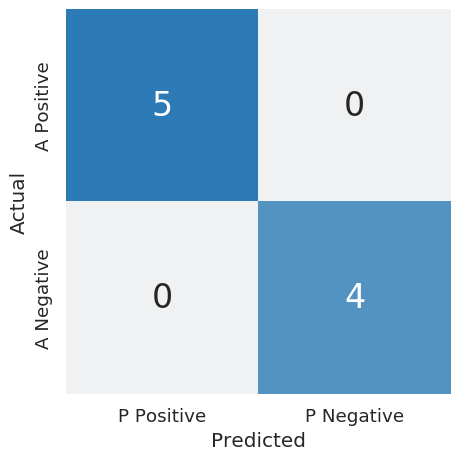

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(df, type, centerID):
    # Filter the DataFrame based on 'best' and 'centerID'
    filtered_df = df[(df['type'] == type) & (df['center'] == centerID)]
    
    color = center_colors[centerID]
    # Populate the confusion matrix from the DataFrame
    
    # Create a 2x2 matrix for plotting
    matrix = [
        [int(filtered_df['TP'].iloc[0]), int(filtered_df['FP'].iloc[0])],
        [int(filtered_df['FN'].iloc[0]), int(filtered_df['TN'].iloc[0])]
    ]
    matrix_df = pd.DataFrame(matrix, 
        index=['Actual Positive', 'Actual Negative'], 
        columns=['Predicted Positive', 'Predicted Negative'])

    print(np.array(matrix).shape, matrix_df.shape)
    # Plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(5, 5))
    sns.heatmap(matrix_df, annot=matrix, fmt='g', cmap=sns.light_palette(color, as_cmap=True), cbar=False
                , square=True,
                xticklabels=['P Positive', 'P Negative'],
                yticklabels=['A Positive', 'A Negative'],
                annot_kws={'fontsize' : 24})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    #plt.title(f'Confusion Matrix for best {best}, {centerID}')
    plt.show()


# Usage
plot_confusion_matrix(metrics_df, 'best level', 'Cologne')


In [ ]:
metrics_df.to_csv('ProjNetMerged4_metrics.csv', index=0)

## Effect Threshold Error

In [ ]:
contact_comparison_df

,centerID,patientID,leadID,hemisphere,contact,amplitude_pred,best_contact_rank_pred,best_contact_pred,amplitude_label,best_contact_rank_label,best_contact_label,matching?,effect_threshold_error
0,Bern,1.0,1.0,right,1,3.0,2,False,3.0,2,False,True,0.0
1,Bern,1.0,1.0,right,2,3.5,4,False,3.5,4,False,True,0.0
2,Bern,1.0,1.0,right,3,2.5,1,True,2.5,1,True,True,0.0
3,Bern,1.0,1.0,right,4,5.0,7,False,5.0,7,False,True,0.0
4,Bern,1.0,1.0,right,5,4.0,6,False,4.0,6,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,Cologne,238.0,238.0,right,6,2.0,1,True,1.0,1,True,True,1.0
420,Cologne,239.0,239.0,right,2,3.0,1,True,3.0,1,True,True,0.0
421,Cologne,239.0,239.0,right,3,3.0,1,True,3.0,1,True,True,0.0
422,Cologne,239.0,239.5,left,9,5.0,2,False,5.0,3,False,True,0.0


/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

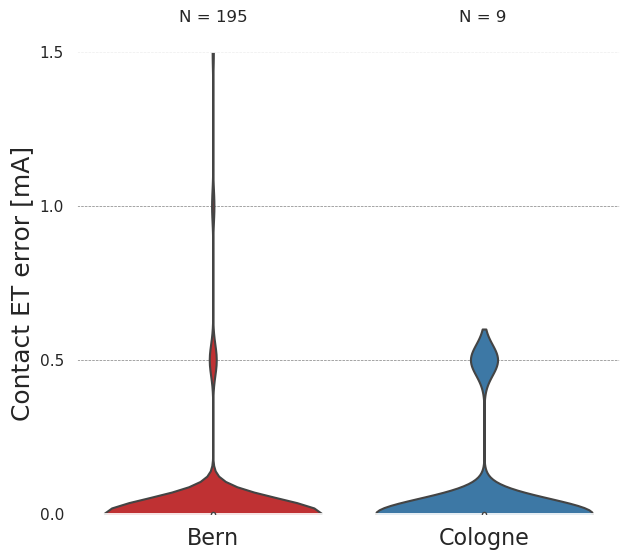

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color

sns.set()

def hex_to_rgba(hex_str, alpha=1.0):
    rgb = hex2color(hex_str)  # This will convert '#XXXXXX' format to a (r, g, b) tuple
    return (*rgb, alpha) 
# Create the horizontal bar plot
if CV_TYPE == 'lopo':
    ncols=2
else:
    ncols=1

fig, ax = plt.subplots(ncols=ncols,figsize=(7, 6))

max_ = level_comparison_df['effect_threshold_error'].max()
sns.violinplot(
    data=level_comparison_df, 
    y='effect_threshold_error', 
    x='center', 
    scale='width', 
    bw=.3, 
    palette=center_colors, 
    ax=ax if CV_TYPE == 'loco' else ax[0])

if CV_TYPE == 'lopo':
    sns.violinplot(
        data=level_comparison_df, 
        y='effect_threshold_error', 
        scale='width', 
        bw=.3, 
        width=0.4, 
        color=center_colors['All'], 
        ax=ax[1])

#ax.set_ylim(0, None)
if CV_TYPE == 'lopo':
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('Contact ET error [mA]', fontdict={'fontsize' : 18})
    ax[1].set_ylabel('')
    #plt.tight_layout()

    # Set the font size of the x-axis tick labels
    ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=16)
    ax[1].set_xticklabels(['All'], fontsize=16)
    ax[1].set_yticks([])

    # Set background to transparent
    ax[0].set_facecolor('none')
    ax[0].figure.set_facecolor('none')
    ax[1].set_facecolor('none')
    #ax[1].figure.set_facecolor('none')

    # Remove the grid and box but keep the ticks
    sns.despine(left=True, bottom=True)

    # Set background to transparent
    fig.set_facecolor('none')
    #plt.savefig(figures_path + 'level_effect_threshold_error_violin.png')
    max_ = 2.0
    ax[0].set_ylim(0, max_)
    ax[1].set_ylim(0, max_)
    ax[0].set_yticks(np.arange(0, max_ + 0.5, 0.5))
    ax[0].yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
    ax[1].set_yticks(np.arange(0, max_ + 0.5, 0.5))
    ax[1].yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')
else:
    ax.set_xlabel('')
    ax.set_ylabel('Contact ET error [mA]', fontdict={'fontsize' : 18})
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_facecolor('none')
    ax.figure.set_facecolor('none')
    ax.set_ylim(0, max_)
    ax.set_yticks(np.arange(0, max_ + 0.5, 0.5))
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray')



# Calculate the number of samples for each centerID
sample_count = level_comparison_df['center'].value_counts()

# Annotate the graph
for idx, center in enumerate(contact_comparison_df['center'].unique()):
    count = sample_count[center]
    x_pos = (idx / len(contact_comparison_df['center'].unique()))*0.77  # x position normalized to figure width
    fig.text(x_pos + 0.32, 0.93, f'N = {count}', ha='center')  # adjust 0.07 and 1.01 to place text accurately
if CV_TYPE == 'lopo':
    fig.text(0.73, 0.93, f'N = {sample_count.sum()}', ha='center')

plt.show()

## Spearman rank corr coeff

In [ ]:
contact_comparison_df

,centerID,patientID,leadID,hemisphere,contact,amplitude_pred,best_contact_rank_pred,best_contact_pred,amplitude_label,best_contact_rank_label,best_contact_label,matching?,effect_threshold_error
0,Bern,1.0,1.0,right,1,3.0,2,False,3.0,2,False,True,0.0
1,Bern,1.0,1.0,right,2,3.5,4,False,3.5,4,False,True,0.0
2,Bern,1.0,1.0,right,3,2.5,1,True,2.5,1,True,True,0.0
3,Bern,1.0,1.0,right,4,5.0,7,False,5.0,7,False,True,0.0
4,Bern,1.0,1.0,right,5,4.0,6,False,4.0,6,False,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,Cologne,238.0,238.0,right,6,2.0,1,True,1.0,1,True,True,1.0
420,Cologne,239.0,239.0,right,2,3.0,1,True,3.0,1,True,True,0.0
421,Cologne,239.0,239.0,right,3,3.0,1,True,3.0,1,True,True,0.0
422,Cologne,239.0,239.5,left,9,5.0,2,False,5.0,3,False,True,0.0


In [ ]:
cnt_stats

,r,dof,pval,CI95%,power
Bern,0.988107,322,6.624074e-264,"[0.99, 0.99]",1.000000
Cologne,0.618347,6,1.022335e-01,"[-0.15, 0.92]",0.399392


In [ ]:
lvl_stats

,r,dof,pval,CI95%,power
Bern,0.969432,117,3.070657e-73,"[0.96, 0.98]",1.000000
Cologne,0.507833,4,3.037337e-01,"[-0.52, 0.93]",0.184917


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_corr(df):
    # Create subplots
    fig, ax = plt.subplots(figsize=(8,4))

    # Create an index for each tick position
    ind = np.arange(0, len(df)*2, 2)


    center_colors = {
        'Bern' : '#d7191c',
        'Cologne' : '#2c7bb6',
        'All' : '#5e3c99'
    }

    # Specify colors based on location
    colors = ['#d7191c' if loc == 'Bern' else '#2c7bb6' if loc == 'Cologne' else '#5e3c99' for loc in df.index]

    # Width of each bar
    width = 0.35

    # Prepare y-error list
    yerr_lower = [abs(r - lower) for r, (lower, upper) in zip(df['r'], df['CI95%'])]
    yerr_upper = [abs(upper - r) for r, (lower, upper) in zip(df['r'], df['CI95%'])]
    yerr_asym = [yerr_lower, yerr_upper]

    # Plot data
    rects = ax.bar(ind, df['r'], width, color=colors, yerr=yerr_asym, capsize=5)

    # Add some text for labels, title and axes ticks
    ax.set_ylabel('repeated measure correlation')
    ax.set_title('')
    ax.set_xticks(ind)
    ax.set_xticklabels(df.index)  # Using the reset index for x-tick labels

    # Annotate with significance markers
    for i, (p, rect) in enumerate(zip(df['pval'], rects)):
        if p > 0.05:
            text = 'N.S.'
        elif p > 0.01:
            text = '*'
        elif p > 0.001:
            text = '**'
        else:
            text = '***'

        ax.text(rect.get_x() + rect.get_width()/2., 1.0, text, ha='center', va='bottom')
        
    ax.set_facecolor('white')
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    plt.show()


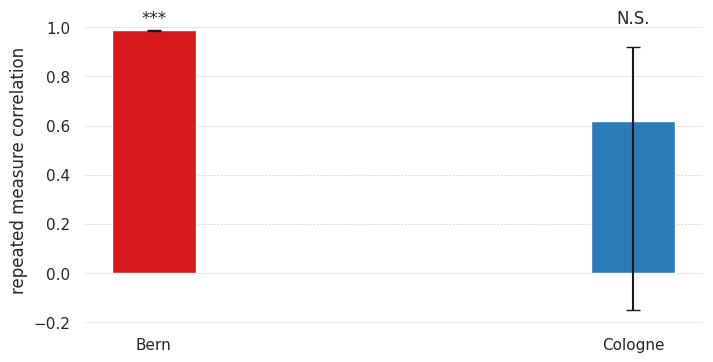

In [ ]:
plot_corr(cnt_stats)

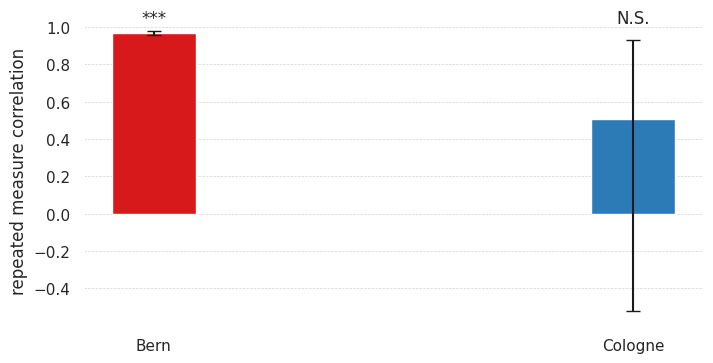

In [ ]:
plot_corr(lvl_stats)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Define a custom function to compute Spearman correlation for a group
def compute_spearman_cnt(group):
    corr, p_value = spearmanr(group['best_contact_rank_pred'], group['best_contact_rank_label'], nan_policy='omit')
    return pd.Series({'spearman_corr': corr, 'p_value': p_value})

# Group by 'centerID', 'patientID', 'hemisphere' and apply the custom function
result_cnt = contact_comparison_df.groupby(['centerID', 'patientID', 'hemisphere']).apply(compute_spearman_cnt).reset_index()

print(result_cnt)

   centerID  patientID hemisphere  spearman_corr   p_value
0      Bern        1.0       left            1.0  0.000000
1      Bern        1.0      right            1.0  0.000000
2      Bern        3.0       left            1.0  0.000000
3      Bern        6.0       left            1.0  0.000000
4      Bern        6.0      right            1.0  0.000000
..      ...        ...        ...            ...       ...
89  Cologne      236.0       left            NaN       NaN
90  Cologne      237.0      right            NaN       NaN
91  Cologne      238.0      right            0.5  0.666667
92  Cologne      239.0       left            1.0       NaN
93  Cologne      239.0      right            NaN       NaN

[94 rows x 5 columns]


/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def rank_heatmap(df, type_):
    df_bern = df[df['centerID'] == 'Bern']
    df_cologne = df[df['centerID'] == 'Cologne']
    # Create a DataFrame that counts the frequency of each (predicted, actual) pair
    pivot_table_bern = pd.crosstab(df_bern[f'best_{type_}_rank_label'], 
                            df_bern[f'best_{type_}_rank_pred'])
    pivot_table_cologne = pd.crosstab(df_cologne[f'best_{type_}_rank_label'], 
                            df_cologne[f'best_{type_}_rank_pred'])


    def annotate_heatmap(data, ax=None):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                value = int(data[i, j])
                color = "w" if value > 70 else "black"
                text = ax.text(j+.5, i+.5, value,
                            ha="center", va="center", color=color)

    # Generate the heatmap
    fig, ax = plt.subplots(figsize=(10,5), ncols=2)
    # Adjust the space between subplots
    plt.subplots_adjust(wspace=0.5)
    height=0.62
    bottom=0.185
    width=0.015
    cbar_ax_bern = fig.add_axes([0.45, bottom, width, height])  # [left, bottom, width, height]
    cbar_ax_cologne = fig.add_axes([0.91, bottom, width, height])  # [left, bottom, width, height]
    sns.heatmap(
        pivot_table_bern, 
        annot=False, 
        fmt="d", 
        cmap=sns.light_palette("#d7191c", as_cmap=True), 
        ax=ax[0],
        cbar_ax=cbar_ax_bern)
    sns.heatmap(
        pivot_table_cologne, 
        annot=False, 
        fmt="d", 
        cmap=sns.light_palette('#2c7bb6', as_cmap=True), 
        ax=ax[1],
        cbar_ax=cbar_ax_cologne)

    # Annotate each cell manually
    #annotate_heatmap(pivot_table.values, ax=ax)

    # Reverse the y-axis
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    if type_ == 'contact':
        df_n = contact_comparison_df
    else:
        df_n = level_comparison_df

    Ns = {
        0 : df_n.groupby(['centerID'])['leadID'].nunique().loc['Bern'],
        1 : df_n.groupby(['centerID'])['leadID'].nunique().loc['Cologne'],
    }
    for i in range(2):
        ax[i].set_xlabel('Predicted Rank')
        ax[i].set_ylabel('Actual Rank')
        ax[i].set_aspect('equal', 'box')
        ax[i].set_title(f'N = {Ns[i]}')


    plt.show()


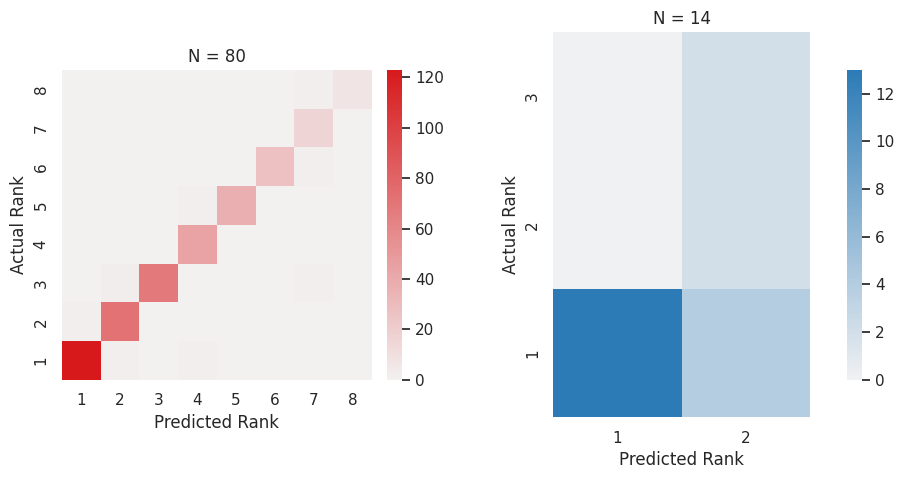

In [ ]:
rank_heatmap(contact_comparison_df, type_='contact')

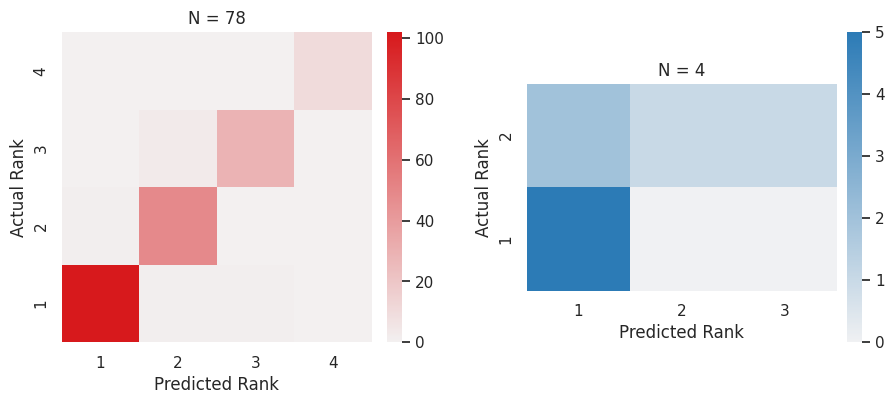

In [ ]:
rank_heatmap(level_comparison_df, type_='level')

In [ ]:
result_cnt.groupby(['centerID'])['spearman_corr'].mean()

centerID
Bern       0.969321
Cologne    0.833333
Name: spearman_corr, dtype: float64

In [ ]:
def compute_spearman_lvl(group):
    corr, p_value = spearmanr(group['best_level_rank_pred'], group['best_level_rank_label'])
    return pd.Series({'spearman_corr': corr, 'p_value': p_value})

result_lvl = level_comparison_df.groupby(['centerID', 'patientID', 'hemisphere']).apply(compute_spearman_lvl).reset_index()

result_lvl['spearman_corr'].mean()

/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/deepmaps_analysis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


0.9661273873616577

In [ ]:
result_lvl.groupby(['centerID'])['spearman_corr'].mean()

centerID
Bern       0.973214
Cologne    0.750000
Name: spearman_corr, dtype: float64

In [ ]:
level_comparison_df[level_comparison_df['centerID'] == 'Cologne']

,centerID,patientID,leadID,hemisphere,level,amplitude_pred,best_level_rank_pred,best_level_pred,amplitude_label,best_level_rank_label,best_level_label,matching?,effect_threshold_error
196,Cologne,208.0,208.0,right,2,4.0,1,True,4.0,1,True,True,0.0
197,Cologne,208.0,208.0,right,3,4.0,1,True,4.0,1,True,True,0.0
198,Cologne,208.0,208.5,left,1,5.0,1,True,5.0,2,False,False,0.0
199,Cologne,208.0,208.5,left,2,5.0,1,True,4.0,1,True,True,1.0
200,Cologne,211.0,211.0,right,0,3.0,1,True,3.0,1,True,True,0.0
201,Cologne,211.0,211.0,right,1,3.0,1,True,4.0,2,False,False,1.0
202,Cologne,211.0,211.0,right,2,4.5,3,False,4.0,2,False,True,0.5
203,Cologne,222.0,222.0,right,2,3.0,1,True,2.0,1,True,True,1.0
204,Cologne,222.0,222.0,right,3,3.5,2,False,3.0,2,False,True,0.5


In [ ]:
df_levels[df_levels['centerID'] == 'Cologne'][['prediction', 'label']].value_counts()

prediction  label
0           0        199
1           0         19
            1         10
0           1          5
Name: count, dtype: int64